# Aprenentatge Supervisat - Regressions

## Nivell 1

### Exercici 1
Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

### Exercici 2
Compara’ls en base al MSE i al R2 .

### Exercici 3
Entrena’ls utilitzant els diferents paràmetres que admeten.

### Exercici 4
Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)




In [1]:
# Librerías

# Data wrangling
#--------------------------------------------------

import numpy as np
import pandas as pd

import missingno as msno 

# Data Visualization
#--------------------------------------------------
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
#--------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Models
#--------------------------------------------------
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Pipelines / Cross validation / Hyp. tunning
#--------------------------------------------------
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, SelectKBest, f_regression


# Metrics
#--------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# File management
#--------------------------------------------------
from joblib import dump, load
import statsmodels.api as sm


Para los primeros cuatro ejercicios voy a seguir el siguiente flujo:
 1. Cargar los archivos.
 2. Preprocesado. 
  - 2.1. Creación de Nuevas variables. 
  - 2.2. Tratamiento missing values.
  - 2.3. EDA / Correlación de variables.
  - 2.4. Tratamiento de variables categóricas.
 3. Instaciación y ajuste de modelos.
 4. Evaluación de los modelos.
 


In [2]:
# Loading CSV
df=pd.read_csv('vuelos_final.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936756 entries, 0 to 1936755
Data columns (total 32 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   DayOfYear          int64  
 2   Year               int64  
 3   Month              int64  
 4   Day                int64  
 5   DayOfWeek          int64  
 6   Hour               int64  
 7   Status             object 
 8   ArrDelay           float64
 9   DepDelay           float64
 10  TaxiIn             float64
 11  TaxiOut            float64
 12  CancellationCode   object 
 13  UniqueCarrier      object 
 14  CarrierName        object 
 15  TailNum            object 
 16  YearOfManufact     float64
 17  Origin             object 
 18  Dest               object 
 19  FlightNum          int64  
 20  Distance           int64  
 21  Skyway             object 
 22  city_or            object 
 23  state_or           object 
 24  country            object 
 25  city_dest         

## 2. Preprocesado.
### 2.1. Creación de nuevas variables.

Voy a crear dos nuevas variables que nos indiquen el número de vuelos por hora y aeropuerto y el numero de vuelos por día y aeropuerto.


In [4]:
# New feature - Number of flights por hour on origin
df=df.join(df.groupby(['Origin','Date','Hour'])[['FlightNum']].count(),
           how='left',
           on=['Origin','Date','Hour'],
           rsuffix='h_')

In [5]:
# New feature - Number of flights por day on origin
df=df.join(df.groupby(['Origin','Date'])[['FlightNum']].count(),
           how='left',
           on=['Origin','Date'],
           rsuffix='d_')

In [6]:
df.rename(columns={'FlightNumh_':'flights_hour',
                   'FlightNumd_':'flights_day'}, inplace=True)

Elimino variables como:

 - Date,Year
 - CancellationCode.
 - CarrierName, TailNum, FlightNum.
 - city_or, state_or, city_dest, state_dest, country.

In [7]:
# Drop features
df.drop(axis=1,columns=['Date','Year','CancellationCode','CarrierName','TailNum','FlightNum',
                        'city_or','state_or','city_dest','state_dest','country'], inplace=True)

In [8]:
# df.info()

In [9]:
df.head(3)

,DayOfYear,Month,Day,DayOfWeek,Hour,Status,ArrDelay,DepDelay,TaxiIn,TaxiOut,...,Dest,Distance,Skyway,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,flights_hour,flights_day
0,3,1,3,4,19,On time,-14.0,8.0,4.0,8.0,...,TPA,810,IAD-TPA,NaN,NaN,NaN,NaN,NaN,6,95
1,3,1,3,4,7,On time,2.0,19.0,5.0,10.0,...,TPA,810,IAD-TPA,NaN,NaN,NaN,NaN,NaN,9,95
2,3,1,3,4,6,On time,14.0,8.0,3.0,17.0,...,BWI,515,IND-BWI,NaN,NaN,NaN,NaN,NaN,2,39


### 2.2. Tratamiento de valores nulos.

In [10]:
df.isna().sum()

DayOfYear                 0
Month                     0
Day                       0
DayOfWeek                 0
Hour                      0
Status                    0
ArrDelay               8387
DepDelay                  0
TaxiIn                 7110
TaxiOut                 455
UniqueCarrier             0
YearOfManufact       198385
Origin                    0
Dest                      0
Distance                  0
Skyway                    0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
flights_hour              0
flights_day               0
dtype: int64

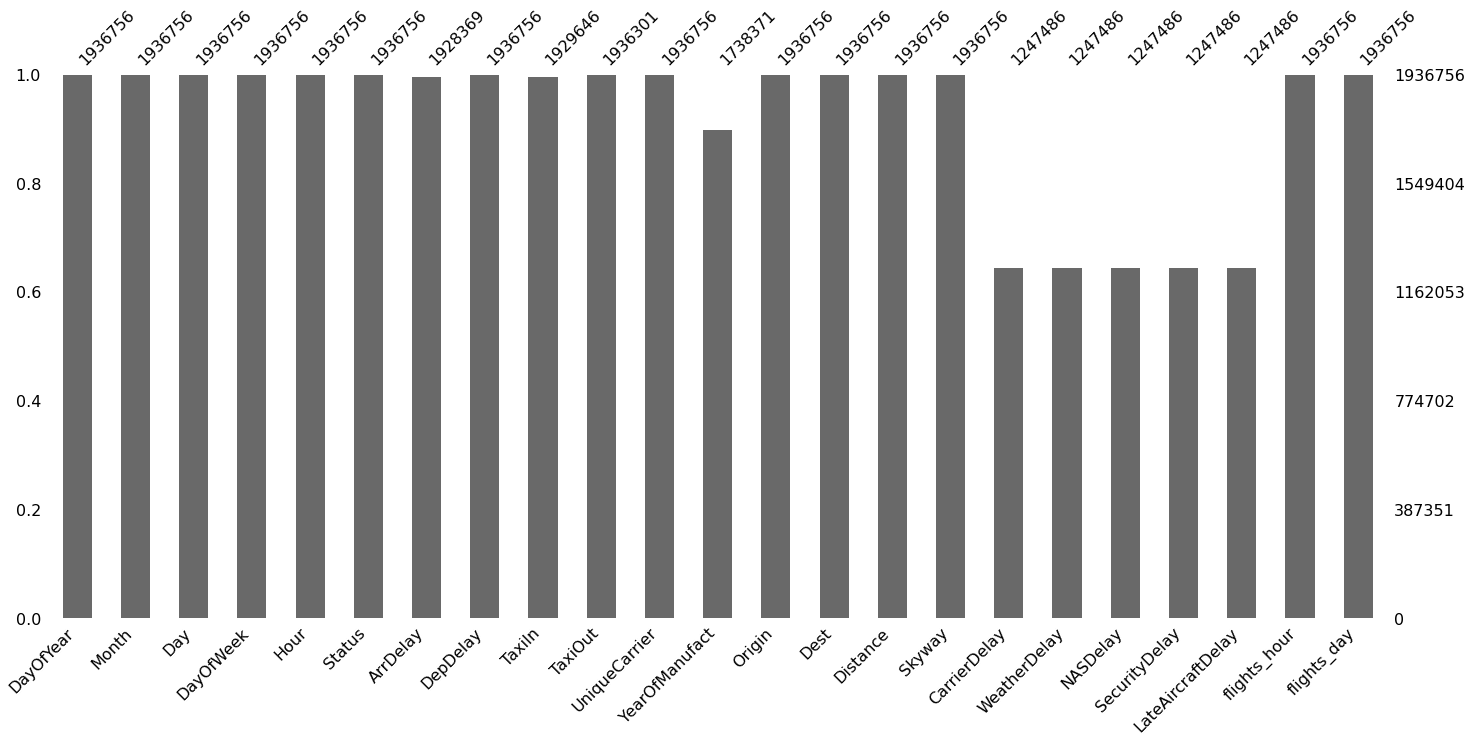

In [11]:
# Missing Values
msno.bar(df);

Tenemos tres conjuntos de valores nulos, que trataremos de manera diferente:
 1. Valores asociados a vuelos cancelados o desviados en las variables ArrDelay, DepDelay, TaxiIn y TaxiOut. Eliminaremos las filas de vuelos cancelados o desviados.
 2. Valores nulos asociados al año de fabricación. Imputaremos la media.
 3. Valores asociados a vuelos a tiempo. Imputaremos valor constante igual a cero.

In [12]:
# Delaying Nan in Taxi In, Taxi Out and ArrDelay
df.drop(index=df[(df.Status=='Cancelled') | (df.Status=='Diverted')].index,
        axis=0,inplace=True)
df.Status.unique()

array(['On time', 'Delayed', 'Highly Delayed'], dtype=object)

In [13]:
# Mean imputing for year of manufacturing
year_imputer=SimpleImputer(strategy='mean')

df.YearOfManufact=year_imputer.fit_transform(df.YearOfManufact.values.reshape(-1,1))


In [14]:
# Zero imputing for Delay Causes

causes_imputer=SimpleImputer(strategy='constant', fill_value=0)

In [15]:
causes=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']

df[causes]=causes_imputer.fit_transform(df[causes])

In [16]:
df.isna().sum().sum()

0

In [17]:
df.to_csv('vuelos_final_pre.csv',index=False)

# Correlation Matrix

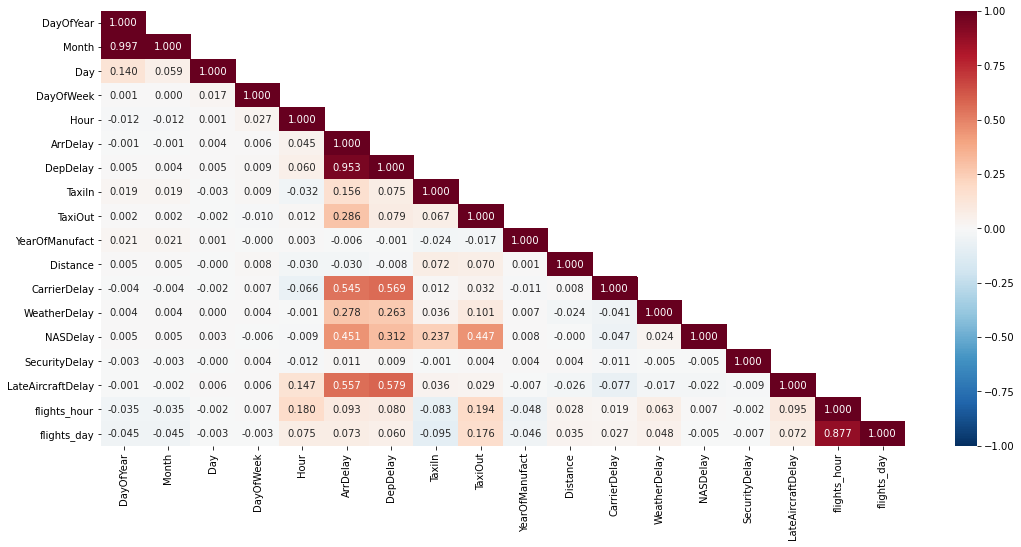

In [20]:

# Matriz de correlación de las variables numéricas
#---------------------------------------------------------------------------
fig, axes = plt.subplots(figsize=(18, 8))

sns.heatmap(df.corr(),
           vmin=-1.0,
           vmax=1.0,
           annot=True, fmt='.3f',
           mask=np.tri(18,18,k=-1,dtype=bool).T,
           cmap='RdBu_r');

La variable ArrDelay, presenta una alta correlación con DepDelay, una correlación media con el grupo de causas de retraso y una correlación baja con las variables de tiempo en tierra (taxi in y taxi out).

In [21]:
#sns.pairplot(df);

## Categorical features

Tenemos 5 variables categóricas con un elevado número de clases (303 aeropuertos de destino o más de 5000 rutas). Para la transformación numérica de estas variables utilizaré el método OrdinalEncoder, que asigna valores numéricos dando un orden a cada categoría. Creo que utilizar OneHotEncoding generaría un dataset con muchas features que dificultarñia el trabajo de computación. 

Esta aproximación podría tener sentido para categías como Status donde ordeno de mayor a menor el estado en función del tiempo de espera, pero no tiene mucho sentido con otras variables como Origin o Skyway.

En la última parte del ejercicio probaré una aproximación diferente para codificar las variables categóricas.

In [22]:
# Label encodind for status
#Instanciar Encoder
status_label=OrdinalEncoder(categories=[np.array(['On time','Delayed', 'Highly Delayed','Cancelled','Diverted'])])
# Transforma variable
df.Status=status_label.fit_transform(df['Status'].values.reshape(-1,1))

In [23]:
#  Label encoding for Origin
# Instanciar encoder
geo_encoding=OrdinalEncoder()
# Declarar variables
geo=['UniqueCarrier','Origin','Dest','Skyway']
# Transformar variables
df[geo]=geo_encoding.fit_transform(df[geo])

## Modelado.

In [24]:
# Preparación dataset
X=df.drop(columns=['DayOfYear','flights_day','ArrDelay'])
y=df['ArrDelay']

# División en train/test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1984,test_size=0.2)

In [25]:
models={}

**Linear Regression**

In [26]:
modelo='Linear'

# Standarizar valores
scaler=StandardScaler()
X_train_transform=scaler.fit_transform(X_train) # Entreno y transformo
X_test_transform=scaler.transform(X_test) # Transformo con los datos del train test

#Instanciar el modelo
linearReg=LinearRegression()

#Ajustar el modelo
linearReg.fit(X_train_transform,y_train)

#Evaluar el modelo
y_pred=linearReg.predict(X_test_transform)

linearReg_MAE=(mean_absolute_error(y_test,y_pred))
linearReg_MSE=(mean_squared_error(y_test,y_pred))
linearReg_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
linearReg_R2=r2_score(y_test,y_pred)

models[modelo]=(linearReg_R2,linearReg_MAE,linearReg_MSE,linearReg_MRSE)

**ElasticNet**

In [27]:
modelo='ElasticNet'

# Standarizar valores
scaler=StandardScaler()
X_train_transform=scaler.fit_transform(X_train) # Entreno y transformo
X_test_transform=scaler.transform(X_test) # Transformo con los datos del train test

#Instanciar el modelo
Elastic=ElasticNet()

#Ajustar el modelo
Elastic.fit(X_train_transform,y_train)

#Evaluar el modelo
y_pred=Elastic.predict(X_test_transform)

Elastic_MAE=(mean_absolute_error(y_test,y_pred))
Elastic_MSE=(mean_squared_error(y_test,y_pred))
Elastic_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
Elastic_R2=r2_score(y_test,y_pred)

models[modelo]=(Elastic_R2,Elastic_MAE,Elastic_MSE,Elastic_MRSE)

**SGDRegressor**

In [28]:
modelo='SGD'

# Standarizar valores
scaler=StandardScaler()
X_train_transform=scaler.fit_transform(X_train) # Entreno y transformo
X_test_transform=scaler.transform(X_test) # Transformo con los datos del train test

#Instanciar el modelo
SGD_R=SGDRegressor()

#Ajustar el modelo
SGD_R.fit(X_train_transform,y_train)

#Evaluar el modelo
y_pred=SGD_R.predict(X_test_transform)

SGD_R_MAE=(mean_absolute_error(y_test,y_pred))
SGD_R_MSE=(mean_squared_error(y_test,y_pred))
SGD_R_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
SGD_R_R2=r2_score(y_test,y_pred)

models[modelo]=(SGD_R_R2,SGD_R_MAE,SGD_R_MSE,SGD_R_MRSE)

**RandomForest**

In [29]:
modelo='Random Forest'

#Instanciar el modelo
rf=RandomForestRegressor(n_jobs=-1,verbose=2)
#Ajustar el modelo
rf.fit(X_train,y_train)

#Evaluar el modelo
y_pred=rf.predict(X_test)

rf_MAE=(mean_absolute_error(y_test,y_pred))
rf_MSE=(mean_squared_error(y_test,y_pred))
rf_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
rf_R2=r2_score(y_test,y_pred)

models[modelo]=(rf_R2,rf_MAE,rf_MSE,rf_MRSE)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.8s finished


In [30]:
# Saving random forest model
dump(rf,'ramdom_forest_01.joblib')


['ramdom_forest_01.joblib']

In [31]:
rf=load('ramdom_forest_01.joblib')

In [32]:
pd.DataFrame.from_dict(models,orient='index',columns=['r_2','MAE','MSE','MRSE']).sort_values(by='MAE')

,r_2,MAE,MSE,MRSE
Random Forest,0.994509,2.009657,17.482007,4.181149
Linear,0.993379,2.803121,21.079161,4.591205
SGD,0.993369,2.808525,21.110931,4.594663
ElasticNet,0.941728,7.833791,185.525995,13.620793


Todos los modelos dan muy buen rendimiento, probabeblente sea debido a la alta correlación entre ArrDelay y DepDelay. Veamos como predice la regresión lineal.

**Diagnóstico regresión lineal**

In [33]:
y_pred=linearReg.predict(X_test_transform)
residuos=y_pred-y_test

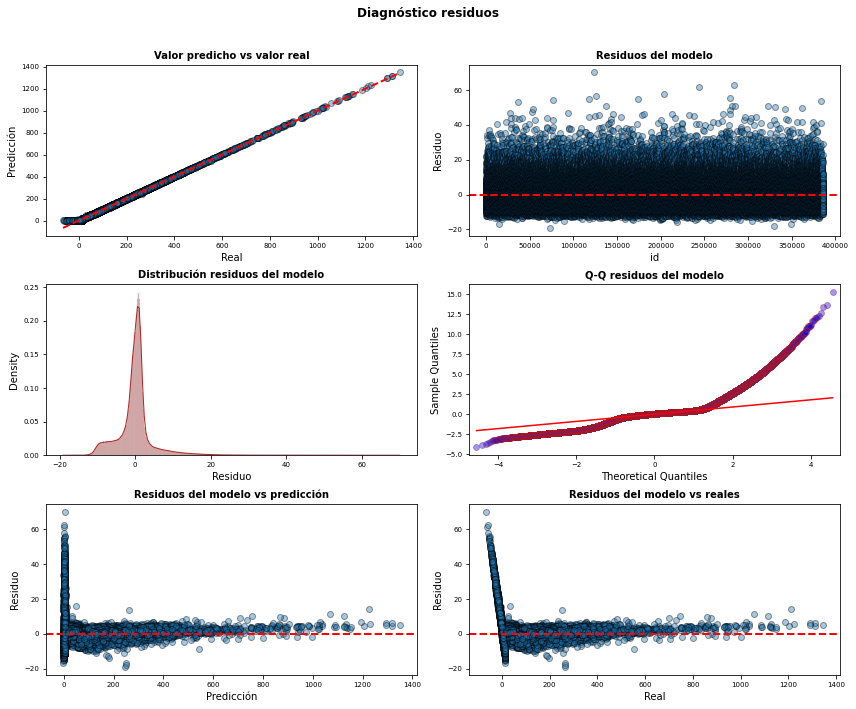

In [34]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(y_test, y_pred, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'k--', color = 'red', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_test))), residuos,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'red', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)


# AX[1,0] Distribución residuos
sns.histplot(
    data    = residuos,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)

# AX[1,1] QQ plot
sm.qqplot(
    residuos,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)


axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

# AX[2,0] Residuos vs prediccion
axes[2, 0].scatter(y_pred, residuos,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'red', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# AX[2,1] Residuos vs real
axes[2, 1].scatter(y_test, residuos,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 1].axhline(y = 0, linestyle = '--', color = 'red', lw=2)
axes[2, 1].set_title('Residuos del modelo vs reales', fontsize = 10, fontweight = "bold")
axes[2, 1].set_xlabel('Real')
axes[2, 1].set_ylabel('Residuo')
axes[2, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

En general el modelo ajusta bien, aunque se observa mayor desviación en valores extremos, es decir para valores pequeños (inferiores a  cero) y para valores grandes (mayores de 600 miutos)

**Tunning SDG Regresor**

El modelo SDG regresor (Stochastic Gradient Descent) es recomendado para datasets con elevado número de observaciones. Vamos a intentar mejorar su puntuación, para ello haremos uso de un método de entrenamiento aleatorio del modelo con valildación cruzada, RandomizedSearchCV: 

In [35]:
# Escalar datos
X_train_transform=scaler.fit_transform(X_train)
X_test_transform=scaler.transform(X_test)

# Instanciar el modelo

SGD=SGDRegressor()

# Grid del modelo

SGD_params={'penalty':['l1','l2'],
            'alpha':[0.0001,0.001,0.01,0.1,1,10,100],
            'l1_ratio':[0.15,0.30,0.5,0.75,1],
            'fit_intercept':[True,False],
            'max_iter':[100.000],
            'learning_rate':['optimal','invscaling','constant'],}

# Randomized grid

Random_SDG=RandomizedSearchCV(SGD,
                              SGD_params,
                              n_iter=50,
                              scoring='neg_mean_absolute_error',
                              n_jobs=-1,
                              cv=5,
                              verbose=2)

# Ajustando

Random_SDG.fit(X_train_transform,y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SGDRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0.15, 0.3, 0.5, 0.75, 1],
                                        'learning_rate': ['optimal',
                                                          'invscaling',
                                                          'constant'],
                                        'max_iter': [100.0],
                                        'penalty': ['l1', 'l2']},
                   scoring='neg_mean_absolute_error', verbose=2)

In [36]:
Random_SDG.best_score_

-2.8023238454599744

In [37]:
Random_SDG.best_estimator_

SGDRegressor(l1_ratio=0.5, max_iter=100.0, penalty='l1')

In [38]:
# Saving random SDG model
dump(Random_SDG.best_estimator_,'Random_SDG.joblib')

['Random_SDG.joblib']

**Tunning ElasticNet**

Vamos a probar diferentes parametros para el modelo de elasticnet: 

In [39]:
# Escalar datos
X_train_transform=scaler.fit_transform(X_train)
X_test_transform=scaler.transform(X_test)

# Instanciar el modelo

Elastic=ElasticNet()

# Grid del modelo

Elastic_params={'alpha':[0.0001,0.001,0.01,0.1,0.25,0.5,0.75,0.95,1],
            'l1_ratio':[0,0.1,0.25,0.5,0.75,0.9,1],
            'fit_intercept':[True,False],
            'max_iter':[100.000]}

# Randomized grid

Random_elastic=RandomizedSearchCV(Elastic,
                                  Elastic_params,
                                  n_iter=10,
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=-1,
                                  cv=5,
                                  verbose=2)

# Ajustando

Random_elastic.fit(X_train_transform,y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\iukan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16330153.94094816, tolerance: 499012.50581192353
  model = cd_fast.enet_coordinate_descent(


RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1,
                                                  0.25, 0.5, 0.75, 0.95, 1],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0, 0.1, 0.25, 0.5, 0.75,
                                                     0.9, 1],
                                        'max_iter': [100.0]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [40]:
Random_elastic.best_score_

-2.89217326249347

In [41]:
Random_elastic.best_estimator_

ElasticNet(alpha=0.0001, l1_ratio=1, max_iter=100.0)

In [42]:
# Saving random elasticNet model
dump(Random_elastic.best_estimator_,'Random_elastic.joblib')

['Random_elastic.joblib']

**Importancia de las variables en el modelo regresion lineal**

In [43]:
importancia=linearReg.coef_
#for i,v in enumerate(importancia):
#    print('Variable %d - puntuación %.3f' %(i,v))

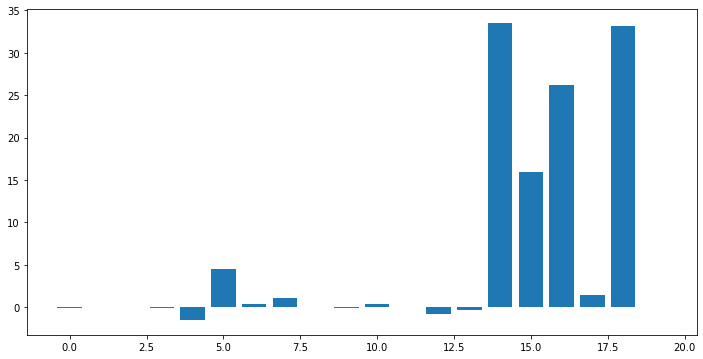

In [44]:
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(importancia))],importancia)
plt.show();

**Importancia modelo elastic net**

In [45]:
importancia_elastic=Random_elastic.best_estimator_.coef_
#for i,v in enumerate(importancia_elastic):
#    print('Variable %d - Importancia: %.3f'%(i,v))

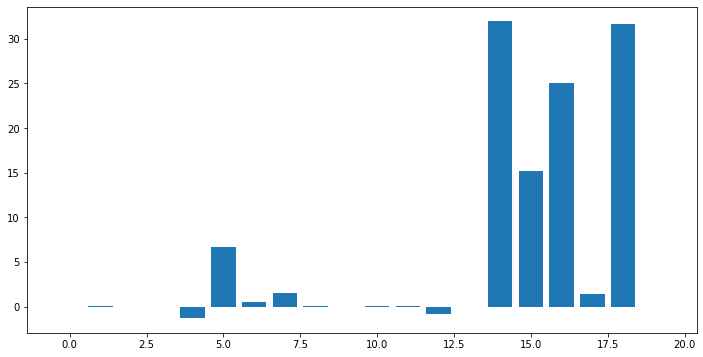

In [46]:
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(importancia_elastic))],importancia_elastic)
plt.show();

**Importancia variables en Random forest**

In [47]:
importancia_random_forest=rf.feature_importances_
#for i,v in enumerate(importancia_random_forest):
#    print('Variable %d - Importancia: %.5f'%(i,v))

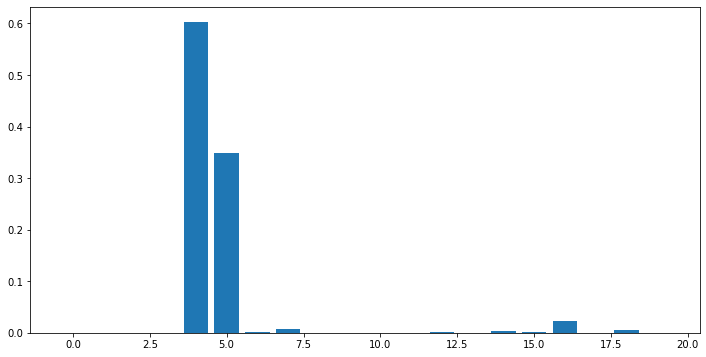

In [48]:
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(importancia_random_forest))],importancia_random_forest)
plt.show();

In [49]:
# Permutation

In [50]:
resultados=permutation_importance(rf,
                                  X_train,
                                  y_train,
                                  scoring='neg_mean_absolute_error')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_job

In [51]:
# Saving importance randon forest model
dump(resultados,'importance_rf.joblib')

importancia_rf = resultados.importances_mean


#for i,v in enumerate(importancia_rf):
#    print('Variable: %0d - Importancia: %.5f' % (i,v))



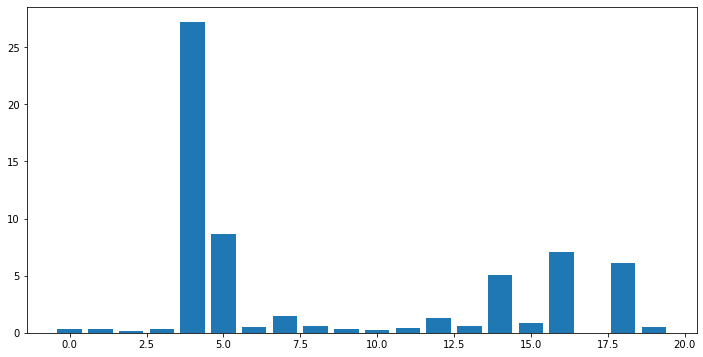

In [52]:
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(importancia_rf))], importancia_rf)
plt.show()

Como podemos ver, cada modelo da diferente importancia a cada variable.

## Nivell 2




### Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció



En este apartado vamos a utilizar una estrategia diferente para codificar las variables categóricas. En el apartado anterior utilizabamos OrdinalEncoder para asignar valores numéricos a los destinos y los orígenes, como habíamos visto son variables que tenían un gran número de categorías y no hay una relación de orden entre ellas. 

In [53]:
df=pd.read_csv('vuelos_final_pre.csv')
df.head()

,DayOfYear,Month,Day,DayOfWeek,Hour,Status,ArrDelay,DepDelay,TaxiIn,TaxiOut,...,Dest,Distance,Skyway,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,flights_hour,flights_day
0,3,1,3,4,19,On time,-14.0,8.0,4.0,8.0,...,TPA,810,IAD-TPA,0.0,0.0,0.0,0.0,0.0,6,95
1,3,1,3,4,7,On time,2.0,19.0,5.0,10.0,...,TPA,810,IAD-TPA,0.0,0.0,0.0,0.0,0.0,9,95
2,3,1,3,4,6,On time,14.0,8.0,3.0,17.0,...,BWI,515,IND-BWI,0.0,0.0,0.0,0.0,0.0,2,39
3,3,1,3,4,17,Delayed,34.0,34.0,3.0,10.0,...,BWI,515,IND-BWI,2.0,0.0,0.0,0.0,32.0,3,39
4,3,1,3,4,19,On time,11.0,25.0,4.0,10.0,...,JAX,688,IND-JAX,0.0,0.0,0.0,0.0,0.0,2,39


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928369 entries, 0 to 1928368
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DayOfYear          int64  
 1   Month              int64  
 2   Day                int64  
 3   DayOfWeek          int64  
 4   Hour               int64  
 5   Status             object 
 6   ArrDelay           float64
 7   DepDelay           float64
 8   TaxiIn             float64
 9   TaxiOut            float64
 10  UniqueCarrier      object 
 11  YearOfManufact     float64
 12  Origin             object 
 13  Dest               object 
 14  Distance           int64  
 15  Skyway             object 
 16  CarrierDelay       float64
 17  WeatherDelay       float64
 18  NASDelay           float64
 19  SecurityDelay      float64
 20  LateAircraftDelay  float64
 21  flights_hour       int64  
 22  flights_day        int64  
dtypes: float64(10), int64(8), object(5)
memory usage: 338.4+ MB


En este caso voy codificar las variables categóricas sustituyendo su valor por la frecuencia con la que aparecen. 

In [55]:
# Label encodind for status
#Instanciar Encoder
#status_label=OrdinalEncoder(categories=[np.array(['On time','Delayed', 'Highly Delayed','Cancelled','Diverted'])])
# Transforma variable
#df.Status=status_label.fit_transform(df['Status'].values.reshape(-1,1))

In [56]:
# Frecuency encoding

categorias=df.select_dtypes(include='object').columns

for cat in categorias: 
    cat_mapping=df.groupby(cat).size()/len(df)*100
    df[cat]=df[cat].map(cat_mapping)


In [57]:
df.head()

,DayOfYear,Month,Day,DayOfWeek,Hour,Status,ArrDelay,DepDelay,TaxiIn,TaxiOut,...,Dest,Distance,Skyway,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,flights_hour,flights_day
0,3,1,3,4,19,35.308751,-14.0,8.0,4.0,8.0,...,1.171197,810,0.021365,0.0,0.0,0.0,0.0,0.0,6,95
1,3,1,3,4,7,35.308751,2.0,19.0,5.0,10.0,...,1.171197,810,0.021365,0.0,0.0,0.0,0.0,0.0,9,95
2,3,1,3,4,6,35.308751,14.0,8.0,3.0,17.0,...,1.532331,515,0.012757,0.0,0.0,0.0,0.0,0.0,2,39
3,3,1,3,4,17,41.468101,34.0,34.0,3.0,10.0,...,1.532331,515,0.012757,2.0,0.0,0.0,0.0,32.0,3,39
4,3,1,3,4,19,35.308751,11.0,25.0,4.0,10.0,...,0.495393,688,0.006586,0.0,0.0,0.0,0.0,0.0,2,39


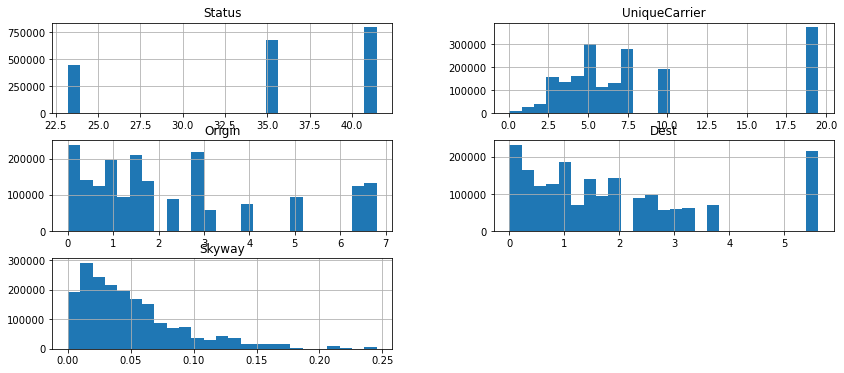

In [58]:
df[categorias].hist(bins=25,figsize=(14,6));

In [59]:
# Preparación dataset
X=df.drop(columns=['DayOfYear','flights_day','ArrDelay'])
y=df['ArrDelay']

# División en train/test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1984,test_size=0.2)

In [60]:
modelo='Linear_2'

# Standarizar valores
scaler=StandardScaler()
X_train_transform=scaler.fit_transform(X_train) # Entreno y transformo
X_test_transform=scaler.transform(X_test) # Transformo con los datos del train test

#Instanciar el modelo
linearReg_2=LinearRegression()

#Ajustar el modelo
linearReg_2.fit(X_train_transform,y_train)

#Evaluar el mopdelo
y_pred=linearReg_2.predict(X_test_transform)

linearReg_2_MAE=(mean_absolute_error(y_test,y_pred))
linearReg_2_MSE=(mean_squared_error(y_test,y_pred))
linearReg_2_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
linearReg_2_R2=r2_score(y_test,y_pred)

models[modelo]=(linearReg_2_R2,linearReg_2_MAE,linearReg_2_MSE,linearReg_2_MRSE)

In [61]:
models.get('Linear_2')

(0.9932172313514586, 2.9434275666716974, 21.594997515194617, 4.647041802608904)

In [62]:
importancia=linearReg_2.coef_
for i,v in enumerate(importancia):
    print('Variable %d - puntuación %.3f' %(i,v))

Variable 0 - puntuación -0.078
Variable 1 - puntuación 0.006
Variable 2 - puntuación -0.008
Variable 3 - puntuación -0.131
Variable 4 - puntuación -0.599
Variable 5 - puntuación 5.807
Variable 6 - puntuación 0.534
Variable 7 - puntuación 1.233
Variable 8 - puntuación 0.219
Variable 9 - puntuación -0.041
Variable 10 - puntuación 0.059
Variable 11 - puntuación -0.196
Variable 12 - puntuación -0.802
Variable 13 - puntuación -0.125
Variable 14 - puntuación 31.809
Variable 15 - puntuación 15.165
Variable 16 - puntuación 24.865
Variable 17 - puntuación 1.382
Variable 18 - puntuación 31.275
Variable 19 - puntuación -0.144


En este caso no se observa mucha mejora puesto que he modificado variables que no tenían mucha importancia en el modelo. Vamos a probar a hacer una variable que sea el logaritmo de la suma de los retrasos por causa.

In [63]:
df['Delay_FPH']=(np.log10(df.CarrierDelay+df.WeatherDelay+df.NASDelay+df.SecurityDelay+df.LateAircraftDelay+1))

In [64]:
# Preparación dataset
X=df.drop(columns=['DayOfYear','flights_day','ArrDelay'])
y=df['ArrDelay']

# División en train/test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1984,test_size=0.2)

In [65]:
modelo='Linear_3'

# Standarizar valores
scaler=StandardScaler()
X_train_transform=scaler.fit_transform(X_train) # Entreno y transformo
X_test_transform=scaler.transform(X_test) # Transformo con los datos del train test

#Instanciar el modelo
linearReg_3=LinearRegression()

#Ajustar el modelo
linearReg_3.fit(X_train_transform,y_train)

#Evaluar el mopdelo
y_pred=linearReg_3.predict(X_test_transform)

linearReg_3_MAE=(mean_absolute_error(y_test,y_pred))
linearReg_3_MSE=(mean_squared_error(y_test,y_pred))
linearReg_3_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
linearReg_3_R2=r2_score(y_test,y_pred)

models[modelo]=(linearReg_3_R2,linearReg_3_MAE,linearReg_3_MSE,linearReg_3_MRSE)

In [66]:
models.get('Linear_3')

(0.9935259454758206, 2.618669167572761, 20.612112635295496, 4.540056457280625)

In [67]:
importancia=linearReg_3.coef_
for i,v in enumerate(importancia):
    print('Variable %d - puntuación %.3f' %(i,v))

Variable 0 - puntuación -0.082
Variable 1 - puntuación 0.001
Variable 2 - puntuación -0.016
Variable 3 - puntuación -0.071
Variable 4 - puntuación -0.223
Variable 5 - puntuación 4.051
Variable 6 - puntuación 0.472
Variable 7 - puntuación 1.019
Variable 8 - puntuación 0.120
Variable 9 - puntuación -0.052
Variable 10 - puntuación -0.007
Variable 11 - puntuación -0.176
Variable 12 - puntuación -0.821
Variable 13 - puntuación -0.108
Variable 14 - puntuación 33.750
Variable 15 - puntuación 16.039
Variable 16 - puntuación 26.330
Variable 17 - puntuación 1.489
Variable 18 - puntuación 33.380
Variable 19 - puntuación -0.008
Variable 20 - puntuación -1.664


Al crear una variable que es el cuadrado del logaritmo de la suma total de retrasos por causa, en esta ocasión hemos mejorado disminuyendo el error absoluto medio. 


## Nivell 3


### Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions

En este caso dejaré fuera del modelo la variable DepDelay.

In [68]:
df=pd.read_csv('vuelos_final_pre.csv')
df.head()

,DayOfYear,Month,Day,DayOfWeek,Hour,Status,ArrDelay,DepDelay,TaxiIn,TaxiOut,...,Dest,Distance,Skyway,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,flights_hour,flights_day
0,3,1,3,4,19,On time,-14.0,8.0,4.0,8.0,...,TPA,810,IAD-TPA,0.0,0.0,0.0,0.0,0.0,6,95
1,3,1,3,4,7,On time,2.0,19.0,5.0,10.0,...,TPA,810,IAD-TPA,0.0,0.0,0.0,0.0,0.0,9,95
2,3,1,3,4,6,On time,14.0,8.0,3.0,17.0,...,BWI,515,IND-BWI,0.0,0.0,0.0,0.0,0.0,2,39
3,3,1,3,4,17,Delayed,34.0,34.0,3.0,10.0,...,BWI,515,IND-BWI,2.0,0.0,0.0,0.0,32.0,3,39
4,3,1,3,4,19,On time,11.0,25.0,4.0,10.0,...,JAX,688,IND-JAX,0.0,0.0,0.0,0.0,0.0,2,39


In [69]:
df['Delay_FPH']=(np.log10(df.CarrierDelay+df.WeatherDelay+df.NASDelay+df.SecurityDelay+df.LateAircraftDelay+1))

In [70]:
# Frecuency encoding

categorias=df.select_dtypes(include='object').columns

for cat in categorias: 
    cat_mapping=df.groupby(cat).size()/len(df)*100
    df[cat]=df[cat].map(cat_mapping)


In [71]:
# Predictores y target
X=df.drop(columns=['DepDelay','ArrDelay'])
y=df['DepDelay']

In [72]:
# División en train/test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1984,test_size=0.2)

**Regrasió Lineal**

In [73]:
modelo_1=Pipeline(steps=[('scaler',StandardScaler()),
                         ('Feature_Selection',SelectKBest(score_func=f_regression)),
                         ('Regressor',LinearRegression())])

hyp_modelo_1={'Feature_Selection__k':[1,2,3,5,9,13,17]}

grid_modelo_1=GridSearchCV(modelo_1,
                           hyp_modelo_1,
                           scoring='neg_mean_absolute_error',
                           cv=10)

In [74]:
grid_modelo_1.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Feature_Selection',
                                        SelectKBest(score_func=<function f_regression at 0x0000018FAC12A550>)),
                                       ('Regressor', LinearRegression())]),
             param_grid={'Feature_Selection__k': [1, 2, 3, 5, 9, 13, 17]},
             scoring='neg_mean_absolute_error')

In [75]:
grid_modelo_1.best_score_

-7.2413850992526125

In [76]:
grid_modelo_1.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()),
                ('Feature_Selection',
                 SelectKBest(k=17,
                             score_func=<function f_regression at 0x0000018FAC12A550>)),
                ('Regressor', LinearRegression())])

In [77]:
y_pred=grid_modelo_1.predict(X_test)

In [78]:
r2_score(y_test,y_pred)

0.9635926095857142

In [79]:
mean_absolute_error(y_test,y_pred)

7.233679125921607

**Arbol de decisión regresor**

In [80]:
# Instanciar el modelo
arbol=DecisionTreeRegressor()

# Ajustar el modelos
arbol.fit(X_train,y_train)

#Evaluar el mopdelo
y_pred=arbol.predict(X_test)

arbol_MAE=(mean_absolute_error(y_test,y_pred))
arbol_MSE=(mean_squared_error(y_test,y_pred))
arbol_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
arbol_R2=r2_score(y_test,y_pred)

arbol_MAE,arbol_MSE,arbol_MSE,arbol_R2

(6.286376577109165, 106.08671442721055, 106.08671442721055, 0.962107824605372)

Hemos mejorado el error medio absoluto utilizando un arbol de decisión regresor, veamos la im portancia de las variables. 

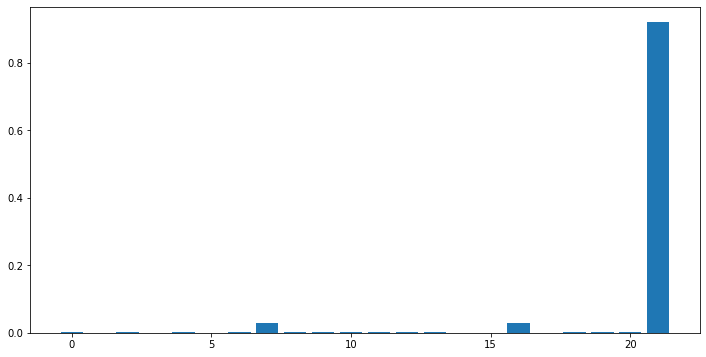

In [81]:
# Feature importance
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(arbol.feature_importances_))],arbol.feature_importances_)
plt.show();

In [82]:
arbol.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

**Random Forest Regresor**

In [83]:
# Instanciar el modelo
rf=RandomForestRegressor(n_estimators=75,max_features='sqrt')

# Ajustar el modelos
rf.fit(X_train,y_train)


RandomForestRegressor(max_features='sqrt', n_estimators=75)

In [84]:
#Evaluar el modelo
y_pred=rf.predict(X_test)

rf_MAE=(mean_absolute_error(y_test,y_pred))
rf_MSE=(mean_squared_error(y_test,y_pred))
rf_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
rf_R2=r2_score(y_test,y_pred)

rf_MAE,rf_MSE,rf_MSE,rf_R2

(4.771271311464548, 55.789115193298464, 55.789115193298464, 0.9800731792908335)

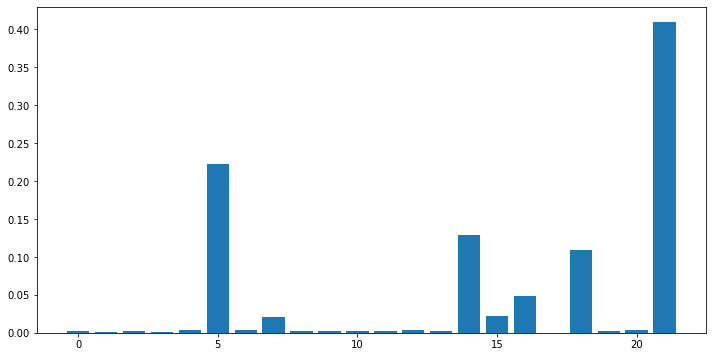

In [85]:
# Feature importance
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(rf.feature_importances_))],rf.feature_importances_)
plt.show();

In [86]:
# Instanciar el modelo
rf2=RandomForestRegressor(n_estimators=75,max_features='auto')

# Ajustar el modelos
rf2.fit(X_train,y_train)

RandomForestRegressor(n_estimators=75)

In [87]:
#Evaluar el modelo
y_pred=rf2.predict(X_test)

rf2_MAE=(mean_absolute_error(y_test,y_pred))
rf2_MSE=(mean_squared_error(y_test,y_pred))
rf2_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
rf2_R2=r2_score(y_test,y_pred)

rf2_MAE,rf2_MSE,rf2_MSE,rf2_R2

(4.771271311464548, 55.789115193298464, 55.789115193298464, 0.9800731792908335)

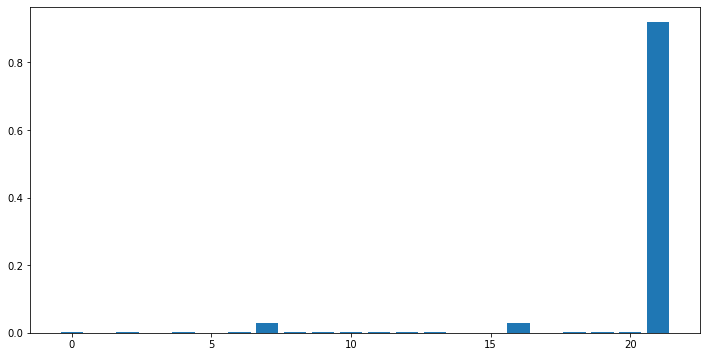

In [88]:
# Feature importance
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(rf2.feature_importances_))],rf2.feature_importances_)
plt.show();

In [89]:
# Instanciar el modelo
rf3=RandomForestRegressor(n_estimators=50,
                          max_features='auto',
                          min_samples_split=10)

# Ajustar el modelos
rf3.fit(X_train,y_train)

#Evaluar el modelo
y_pred=rf.predict(X_test)

rf3_MAE=(mean_absolute_error(y_test,y_pred))
rf3_MSE=(mean_squared_error(y_test,y_pred))
rf3_MRSE=np.sqrt(mean_squared_error(y_test,y_pred))
rf3_R2=r2_score(y_test,y_pred)

rf3_MAE,rf3_MSE,rf3_MSE,rf3_R2

(4.771271311464548, 55.789115193298464, 55.789115193298464, 0.9800731792908335)

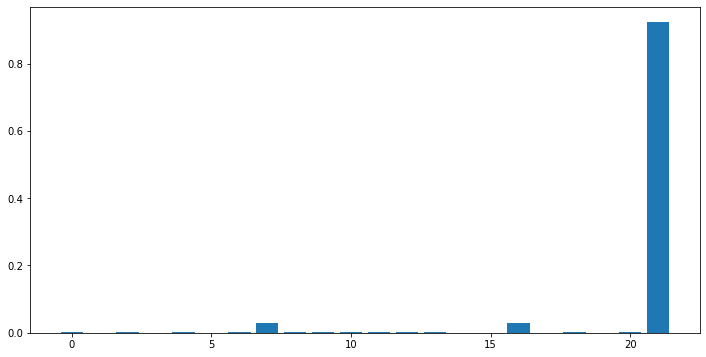

In [90]:
# Feature importance
plt.subplots(figsize=(12,6))
plt.bar([x for x in range(len(rf3.feature_importances_))],rf3.feature_importances_)
plt.show();